# Описание модели k-NN

[Метод k-ближайших соседей 📚[wiki]](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) (англ. k-nearest neighbors algorithm, k-NN) — метрический алгоритм для классификации или регрессии. В случае классификации алгоритм сводится к следующему:

1. Рассматриваются объекты из обучающей выборки, для которых известно, к какому классу они принадлежат.
2. Между подлежащими классификации объектами и объектами тренировочной выборки вычисляется матрица попарных расстояний согласно выбранной метрике.
3. На основе полученной матрицы расстояний для каждого из подлежащих классификации объектов определяются $k$ ближайших объектов тренировочной выборки — $k$ ближайших соседей.
4. Подлежащим классификации объектам приписывается тот класс, который чаще всего встречается у их $k$ ближайших соседей.


<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L01/out/knn_idea.png" width="700" ></center>

Нам даётся описание вин из учебного датасета [Wine 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html), в котором представлены результаты химического анализа вин, выращенных в одном регионе Италии, но полученных из трех разных сортов винограда.


Загрузим датасет, используя модуль `sklearn.datasets` [🛠️[doc]](https://scikit-learn.org/stable/api/sklearn.datasets.html) библиотеки Sklearn.

Библиотека Sklearn обеспечивает API по работе с датасетами, а также хранит ряд учебных. Посмотрим, как это выглядит.


Чтобы отобразить данные в виде таблицы, загрузим их в формате `pandas.DataFrame`.

In [ ]:
from sklearn.datasets import load_wine

x, y = load_wine(return_X_y=True, as_frame=True)

x.head(3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0


Так мы можем посмотреть, какие **уникальные классы** есть в нашей выборке.

In [ ]:
y.unique()

array([0, 1, 2])

Можно интерпретировать каждый объект как координаты точки в 13-мерном пространстве. Именно с таким представлением работает большинство алгоритмов машинного обучения.

Визуализируем распределение данных по классам и отметим, что присутствует дисбаланс.

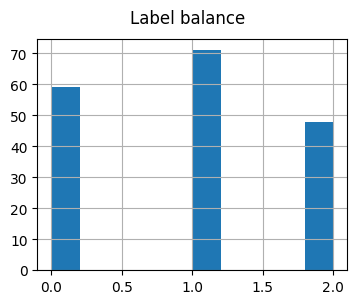

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(4, 3))
y.hist()
plt.suptitle("Label balance")
plt.show()

## Близость данных согласно метрике

Пара бутылок вина будет определяться идентично, если значения характеристик будут похожи по величине. Другими словами, практически идентичным объектам будут соответствовать **близкие** точки многомерного пространства. Для численной характеристики **близости** можно определить функцию подсчета расстояния между парой точек — метрику.

Известны различные способы задания [функции расстояния между парой точек 📚[wiki]](https://en.wikipedia.org/wiki/Metric_(mathematics)). Простейшим примером является широко известная **Евклидова** ($L_2$) метрика:
$$L_2 (X, Y) = \sqrt { \sum_i (X_i - Y_i)^2}$$

Но, кроме неё, величина расстояния между парой точек может быть выражена рядом других функций.

$L_1$-расстояние (манхэттенская метрика):
$$L_1 (X, Y) = \sum_i |X_i - Y_i|$$

Угловое расстояние:
$$\text{ang}(X, Y) = \frac{1}{\pi} \arccos \frac{\sum_i X_i Y_i}{\sqrt{\sum_i X_i^2} \sqrt{\sum_i Y_i^2}}$$

И многие другие. От выбора конкретной функции расстояния между точками будет явно зависеть представление о **близости** точек: объекты, близкие по одной из метрик, вовсе не обязаны оказаться близкими согласно другой.

Попробуем вычислить $L_1$-расстояние между несколькими первыми объектами из набора данных с использованием реализованного в пакете Sklearn класса `sklearn.metrics.DistanceMetric`[🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html#sklearn.metrics.DistanceMetric.get_metric).

Выберем три объекта из выборки:

In [ ]:
from sklearn.datasets import load_wine

x, y = load_wine(return_X_y=True, as_frame=True)

obj_0 = x.iloc[0]
obj_1 = x.iloc[1]
obj_2 = x.iloc[170]

x.iloc[[0, 1, 170]]

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
170,12.20,3.03,2.32,19.0,96.0,1.25,0.49,0.40,0.73,5.50,0.66,1.83,510.0


Два объекта класса 0 и один объект класса 2:

In [ ]:
print(f"obj_0: {y[0]} \nobj_1: {y[1]} \nobj_2: {y[170]}")

obj_0: 0 
obj_1: 0 
obj_2: 2


И посчитаем расстояния между ними:

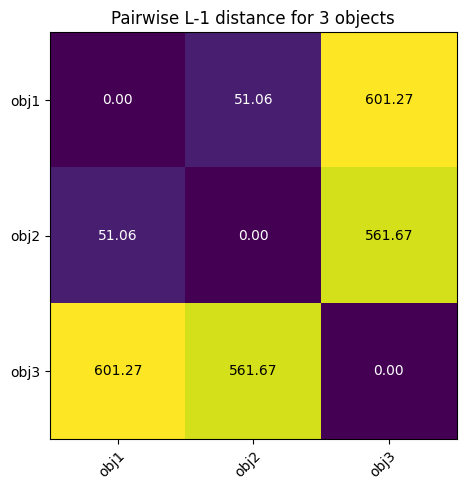

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

pairwise_dist = pairwise_distances([obj_0, obj_1, obj_2], metric="manhattan")

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(pairwise_dist)

labels = [f"obj{i}" for i in range(1, 4)]
ax.set_xticks(np.arange(len(pairwise_dist)))
ax.set_yticks(np.arange(len(pairwise_dist)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(pairwise_dist)):
    for j in range(len(pairwise_dist)):
        text = ax.text(
            j,
            i,
            "{:0.2f}".format(pairwise_dist[i, j]),
            ha="center",
            va="center",
            color="white" if pairwise_dist[i, j] < np.mean(pairwise_dist) else "black",
        )

ax.set_title("Pairwise L-1 distance for 3 objects")
fig.tight_layout()
plt.show()

Рассматривая аналогичные примеры, можно выявить, что расстояние между объектами одного и того же класса может оказаться меньше, чем расстояние между объектами разных классов. Действительно, давайте рассчитаем средние расстояния между объектами разных классов для UCI ML Wine DataSet:

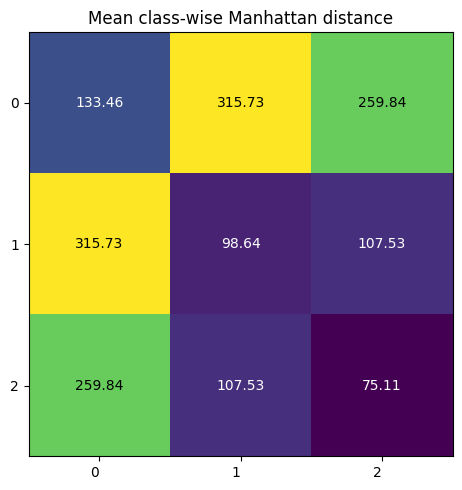

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import manhattan_distances

data = pd.concat([x, y], axis=1)
classwise_distance = np.zeros((len(y.unique()), len(y.unique())))

for i in range(len(y.unique())):
    for j in range(len(y.unique())):
        class_i_data = data[data["target"] == i]
        class_j_data = data[data["target"] == j]
        classwise_distance[i, j] = (
            np.mean(manhattan_distances(class_i_data, class_j_data)) / 2.0
        )

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(classwise_distance)

ax.set_xticks(np.arange(len(y.unique())))
ax.set_yticks(np.arange(len(y.unique())))
ax.set_xticklabels(y.unique())
ax.set_yticklabels(y.unique())
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

for i in range(len(y.unique())):
    for j in range(len(y.unique())):
        text = ax.text(
            j,
            i,
            "{:0.2f}".format(classwise_distance[i, j]),
            ha="center",
            va="center",
            color=(
                "white"
                if classwise_distance[i, j] < np.mean(classwise_distance)
                else "black"
            ),
        )

ax.set_title("Mean class-wise Manhattan distance")
fig.tight_layout()
plt.show()

Как мы видим, для объектов классов в целом выполняется условие обособленности, т.е. отношение близости по манхэтенновскому расстоянию.

Идея о том, что близость объектов по некоторой метрике и их принадлежность к одному определённому классу связаны, является основой известного алгоритма классификации и регрессии — **k-Nearest Neighbors**.

## Задача классификации

Довольно естественно оценивать долю правильных ответов алгоритма как отношение верно предсказанных классов к общему количеству объектов:

$$ \large \text{Accuracy} = \frac{P}{N}, $$



$P$ — количество верно предсказанных классов,


$N$ — общее количество тестовых примеров.


Сделаем разделение на выборки:

In [ ]:
from sklearn.model_selection import train_test_split

# Split data to train and val
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

print("Train:", np.array(x_train).shape, np.array(y_train).shape)
print("Val:", np.array(x_val).shape, np.array(y_val).shape)
print("Total:", np.array(x).shape, np.array(y).shape)

Train: (142, 13) (142,)
Val: (36, 13) (36,)
Total: (178, 13) (178,)


Обучим алгоритм k-NN ([реализации алгоритма в scikit-learn 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.kneighbors_graph)), используя параметры `n_neighbors=6` и `metric="chebyshev"`. Метод `fit` служит для обучения модели, принимает матрицу объектов и вектор меток классов. После чего оценим качество, посчитав `accuracy`:

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=6, metric="chebyshev")
knn.fit(x_train, y_train)
accuracy = accuracy_score(y_pred=knn.predict(x_val), y_true=y_val)  # accuracy

print("Accuracy:", f"{accuracy*100 :0.2f}%")

Accuracy: 72.22%


Метод `fit` настраивает модель. В простейшей реализации метода k-NN во время обучения просто запоминаются вектора признаков и их метки. Такая Brute-Force реализация самая медленная, существуют [более оптимальные реализации алгоритма ✏️[blog]](https://habr.com/ru/articles/801885/).

## Задача регрессии

В задаче **регрессии** мы используем входные **признаки**, чтобы предсказать **целевые значения**, являющиеся вещественными числами. Например, можно предсказывать цену жилья по его характеристикам (площадь, этаж, год постройки дома, высота потолков, район, ...).

Зпустим алгоритм k-NN, но для регресии. Работает он следующим образом:
1. Запоминаем объекты обучающей выборки.
2. Для нового объекта ищем $k$ ближайших соседей.
3. Предсказание для нового объекта — **это среднее значение целевой переменной $k$ ближайших соседей**.


Сгенерируем данные для демонстрации:

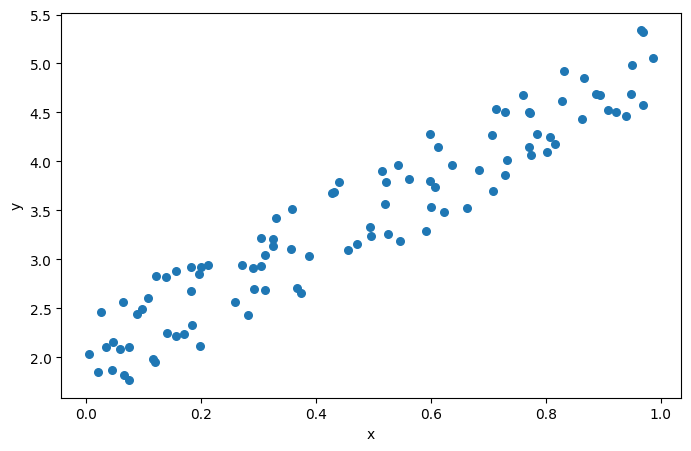

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(42)
x = np.random.rand(100, 1)
y = 2 + 3 * x + (np.random.rand(100, 1) - 0.5)

plt.figure(figsize=(8, 5))
plt.scatter(x, y, s=30)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Сделаем разделение на выборки:

In [ ]:
from sklearn.model_selection import train_test_split

# Split data to train and val
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

print("Train:", np.array(x_train).shape, np.array(y_train).shape)
print("Val:", np.array(x_val).shape, np.array(y_val).shape)
print("Total:", np.array(x).shape, np.array(y).shape)

Train: (80, 1) (80, 1)
Val: (20, 1) (20, 1)
Total: (100, 1) (100, 1)


Обучим `KNeighborsRegressor` [🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) и сделаем предсказание на отложенной выборке:

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn_regressor = KNeighborsRegressor(n_neighbors=3)
knn_regressor.fit(x_train, y_train)
y_pred = knn_regressor.predict(x_val)
print(f"predicted: {y_pred}")

predicted: [[3.57571878]
 [5.23612644]
 [3.60959585]
 [4.38365959]
 [3.59897112]
 [2.58737568]
 [3.83046542]
 [4.1714615 ]
 [4.1714615 ]
 [4.84391852]
 [4.35110955]
 [3.37171184]
 [2.19747243]
 [3.60959585]
 [2.6357678 ]
 [3.48809083]
 [2.54706058]
 [2.04915387]
 [2.28800407]
 [5.11369912]]


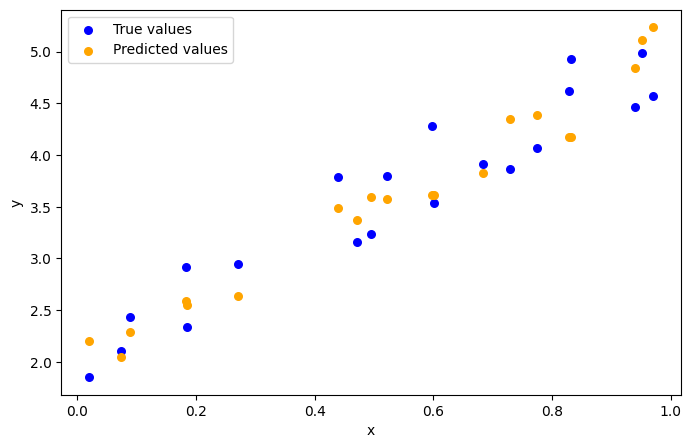

In [ ]:
# Plot true vs predicted values
plt.figure(figsize=(8, 5))
plt.scatter(x_val, y_val, color="blue", label="True values", s=30)
plt.scatter(x_val, y_pred, color="orange", label="Predicted values", s=30)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()